# **Problema de *Machine Learning***

## **Definição do problema**

**Descrição**

Embora muitas pessoas tenham sido acometidas pelo covid-19, parece que alguns grupos de pacientes foram mais afetados do que outros, por diferentes motivos. Neste trabalho, será estudada se uma pessoa tem mais chance de se infectar e/ou falecer devido ao covid-19, considerando a cor da pele dessa pessoa.


**Tipo de problema**

Esse problema é de aprendizado supervisionado, pois, com base nos casos de pessoas fornecidos previamente, o modelo será treinado para prever se uma pessoa tem mais chance de falecer devido ao covid-19.

**Hipótese**

Pessoas afrodescendentes têm mais chance de falecerem devido ao covid-19 do que pessoas brancas no estado de São Paulo.

**Restrições e condições**

Neste trabalho, os dados utilizados foram disponibilizados pela Fundação SEADE, referentes a vítimas de covid-19 do estado de São Paulo: https://repositorio.seade.gov.br/dataset/covid-19/resource/a730d5c1-7899-4455-8649-68e7e8cc1753


**Atributos do dataset**

As definições *dos* atributos a seguir também estão disponíveis em https://repositorio.seade.gov.br/dataset/covid-19/resource/f9692def-0c04-4329-8cf9-d1ebbc35c840

1. codigo_ibge: código numérico do município no IBGE (7 dígitos) de residência do paciente
2. nome_munic: nome do município de residência do paciente
3. nome_drs: nome do departamento regional da saúde de residência do paciente
4. obito: indica se o paciente veio a óbito por covid-19
5. raca_cor: cor ou raça do paciente
6. idade: idade do paciente
7. cs_sexo sexo do paciente
8. diagnostico_covid19: confirmação de covid-19
9. asma: paciente tem asma
10. cardiopatia: paciente tem cardiopatia
11. diabetes: paciente tem diabetes
12. doenca_hematologica: paciente tem doença hematológica
13. doenca_hepatica: paciente tem doença hepática
14. doenca_neurologica: paciente tem doença neurológica
15. doenca_renal: paciente tem doença renal
16. imunodepressao: paciente tem imunodepressão
17. obesidade: paciente tem obesidade
18. pneumopatia: paciente tem pneumopatia
19. puerpera: paciente é puérpera
20. sindrome_de_down: paciente tem síndrome de down

## **Preparação de dados**

### ***Dataset* de treino e teste**

Seja *n* a quantidade de linhas do arquivo disponível em https://media.githubusercontent.com/media/anttoniol/pucrio_ds_sprint2/main/casos_obitos_raca_cor.csv, O *dataset* de treino contém cerca de 75% das linhas do arquivo e os 25% restantes serão utilizados como teste. Cada *dataset* foi gerado de forma pseudoaleatória (devido às limitações da biblioteca *random* do *Python*) e está disponível no repositório.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, jaccard_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier # ExtraTrees, para a Importância de Atributos
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
url = "https://media.githubusercontent.com/media/anttoniol/pucrio_ds_sprint2/main/casos_obitos_raca_cor.csv"
dataframe = pd.read_csv(url, sep = ";")
len(dataframe.index)

6578136

In [4]:
original_dataframe = dataframe.copy()

### **Sobre a necessidade de validação cruzada**
Neste MVP, a validação cruzada será utilizada, para uma melhor avaliação, embora o *dataset* tenha uma quantidade significativa de linhas (ou, seja, não é um conjunto muito limitado).


### **Transformação de dados**

Nesta parte, serão realizadas algumas operações para melhorar a qualidade dos dados.

#### **Substituição de valores**

Para cada coluna, os valores desconhecidos serão substituídos e, se a coluna não for numérica, será realizado o *dummy encoder*.

Além disso, algumas colunas foram descartadas, por não serem relevantes na resposta ao problema tratado neste trabalho. Assim, serão consideradas apenas as colunas "raca_cor", "idade", "cs_sexo", "diagnostico_covid19" e "obito":

In [5]:
dataframe = dataframe.loc[:, ~dataframe.columns.isin(["codigo_ibge", "nome_munic", "nome_drs"])]

Como o *dataframe* é muito grande, decidiu-se utilizar 10000 linhas aleatórias do *dataframe*, para que as execuções a seguir pudessem ser feitas completamente, sem travar a máquina utilizada para o desenvolvimento deste MVP.

In [6]:
seed = 7
random.seed(seed)
population = list(range(len(dataframe.index)))
sample = random.sample(population, k = 10000)

dataframe = dataframe.loc[sample, :]

In [7]:
def replace_na_values(dataframe, column_name, new_value):
  new_column = dataframe[column_name].fillna(new_value)
  dataframe[column_name] = new_column
  return dataframe

def apply_dummy_encoding(data, columns = None, prefix_sep = '_'):
  return pd.get_dummies(data = data, columns = columns, prefix_sep = prefix_sep)

def prepare_to_dummy_encoding(dataframe, columns):
  encoded_dataframe = pd.DataFrame(columns = columns)
  encoded_dataframe = pd.concat([encoded_dataframe, dataframe[columns]])
  return apply_dummy_encoding(encoded_dataframe)


**obito**

Os valores faltantes serão substituídos pelo valor -1. Além disso, para facilitar a compreensão, o valor booleano "False" será substituído por 0; o valor booleano "True", por 1.

In [8]:
dataframe = replace_na_values(dataframe, "obito", -1)
#dataframe["obito"].replace(False, 0, inplace = True)
#dataframe["obito"].replace(True, 1, inplace = True)
dataframe


,obito,raca_cor,idade,cs_sexo,diagnostico_covid19,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,pneumopatia,puerpera,sindrome_de_down
2716506,False,BRANCA,24.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
1265414,False,BRANCA,27.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
3312019,False,IGNORADO,64.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
5460434,False,BRANCA,32.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
405055,False,IGNORADO,47.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,BRANCA,31.0,MASCULINO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
1124990,False,PARDA,65.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
2048844,False,BRANCA,48.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN
2164375,False,IGNORADO,54.0,MASCULINO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN


**raca_cor**

Os valores faltantes serão substituídos por "DESCONHECIDA".

In [9]:
def replace_string_values(dataframe, column_name, replacement_dict):
  for key in replacement_dict:
    column =  dataframe[column_name].str.replace(key, replacement_dict[key], regex = True)
    dataframe[column_name] = column
  return dataframe

In [10]:
dataframe = replace_na_values(dataframe, "raca_cor", "DESCONHECIDA")
encoded_dataframe_raca_cor = prepare_to_dummy_encoding(dataframe, ["raca_cor"])
dataframe.drop("raca_cor", axis = 1, inplace = True)
dataframe[list(encoded_dataframe_raca_cor.columns.values)] = encoded_dataframe_raca_cor.values.tolist()
dataframe

,obito,idade,cs_sexo,diagnostico_covid19,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,...,puerpera,sindrome_de_down,raca_cor_AMARELA,raca_cor_BRANCA,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA
2716506,False,24.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,...,NaN,NaN,0,1,0,0,0,0,0,0
1265414,False,27.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,...,NaN,NaN,0,1,0,0,0,0,0,0
3312019,False,64.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,1,0,0,0,0
5460434,False,32.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,...,NaN,NaN,0,1,0,0,0,0,0,0
405055,False,47.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,MASCULINO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,...,NaN,NaN,0,1,0,0,0,0,0,0
1124990,False,65.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,1,0
2048844,False,48.0,FEMININO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,...,NaN,NaN,0,1,0,0,0,0,0,0
2164375,False,54.0,MASCULINO,CONFIRMADO,NaN,9.0,9.0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,1,0,0,0,0


**diagnostico_covid19**

Os valores faltantes serão substituídos pelo valor -1; os campos com "CONFIRMADO", por 1; e o restante, por 0.

In [11]:
dataframe = replace_na_values(dataframe, "diagnostico_covid19", "-1")
encoded_dataframe_diagnostico_covid19 = prepare_to_dummy_encoding(dataframe, ["diagnostico_covid19"])
dataframe.drop("diagnostico_covid19", axis = 1, inplace = True)
dataframe[list(encoded_dataframe_diagnostico_covid19.columns.values)] = encoded_dataframe_diagnostico_covid19.values.tolist()

**idade**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos. A mesma coisa será feita para valores menores que -1 ou maiores do que ou iguais a 130.

In [12]:
median = dataframe["idade"].median()
dataframe = replace_na_values(dataframe, "idade", median)
first_filter = dataframe["idade"] <= -1
second_filter = dataframe["idade"] >= 130
dataframe.loc[first_filter | second_filter, "idade"] = median
dataframe

,obito,idade,cs_sexo,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,...,sindrome_de_down,raca_cor_AMARELA,raca_cor_BRANCA,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO
2716506,False,24.0,FEMININO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,...,NaN,0,1,0,0,0,0,0,0,1
1265414,False,27.0,FEMININO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,...,NaN,0,1,0,0,0,0,0,0,1
3312019,False,64.0,FEMININO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,...,NaN,0,0,0,1,0,0,0,0,1
5460434,False,32.0,FEMININO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,...,NaN,0,1,0,0,0,0,0,0,1
405055,False,47.0,FEMININO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,...,NaN,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,MASCULINO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,...,NaN,0,1,0,0,0,0,0,0,1
1124990,False,65.0,FEMININO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,...,NaN,0,0,0,0,0,0,1,0,1
2048844,False,48.0,FEMININO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,...,NaN,0,1,0,0,0,0,0,0,1
2164375,False,54.0,MASCULINO,NaN,9.0,9.0,NaN,NaN,NaN,9.0,...,NaN,0,0,0,1,0,0,0,0,1


**cs_sexo**

Os valores faltantes serão substituídos pelo valor "DESCONHECIDO".

In [13]:
dataframe = replace_na_values(dataframe, "cs_sexo", "DESCONHECIDO")

encoded_dataframe = prepare_to_dummy_encoding(dataframe, ["cs_sexo"])
dataframe.drop("cs_sexo", axis = 1, inplace = True)
dataframe[list(encoded_dataframe.columns.values)] = encoded_dataframe.values.tolist()
dataframe

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,NaN,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**asma**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [14]:
def replace_na_values_with_median(dataframe, column_name):
  median = dataframe[column_name].median()
  dataframe = replace_na_values(dataframe, column_name, median)
  return dataframe

replace_na_values_with_median(dataframe, "asma")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**cardiopatia**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [15]:
replace_na_values_with_median(dataframe, "cardiopatia")


,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**diabetes**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [16]:
replace_na_values_with_median(dataframe, "diabetes")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,NaN,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**doenca_hematologica**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [17]:
replace_na_values_with_median(dataframe, "doenca_hematologica")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,NaN,NaN,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,NaN,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,NaN,NaN,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**doenca_hepatica**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [18]:
replace_na_values_with_median(dataframe, "doenca_hepatica")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,NaN,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,NaN,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,NaN,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,NaN,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,NaN,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**doenca_neurológica**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [19]:
replace_na_values_with_median(dataframe, "doenca_neurologica")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**doenca_renal**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [20]:
replace_na_values_with_median(dataframe, "doenca_renal")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**imunodepressao**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [21]:
replace_na_values_with_median(dataframe, "imunodepressao")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**obesidade**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [22]:
replace_na_values_with_median(dataframe, "obesidade")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**pneumopatia**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [23]:
replace_na_values_with_median(dataframe, "pneumopatia")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**puerpera**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [24]:
replace_na_values_with_median(dataframe, "puerpera")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


**sindrome_de_down**

Os valores faltantes serão substituídos pela mediana do atributo, para que todos os valores desse atributo sejam numéricos.

In [25]:
replace_na_values_with_median(dataframe, "sindrome_de_down")

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


A célula a seguir gera um arquivo csv a partir do dataframe obtido após as substituições de valores. Uma cópia desse arquivo está no repositório, no arquivo "substitution_result.zip".

In [26]:
#dataframe.to_csv("substitution_result.csv", sep = ";", compression = None)

## **Modelagem e treinamento**

Os algoritmos selecionados para teste são de classificação, pois o problema neste MVP é de classificação:

1. Regressão logística, pois o problema tratado neste trabalho parece bastante de regressão logística, em que a saída do modelo é mapeada para a classe "Mais chance de óbito" ou para a classe "Menos chance de óbito", cada uma representando um valor binário.

2. Naive Bayes, por ser um classificador genérico e de aprendizado dinâmico, além de ser rápido computacionalmente, não necessitar de muitos dados de treinamento e ser adequado para *datasets* com muitos atributos, como o que está sendo usado neste trabalho.

3. SVM, por exigir poucos ajustes, tender a apresentar boa acurácia e ser menos propenso a *overfitting*

Os outros algortimos abordados na aula de classificação **não** foram escolhidos, por questões de performance com *datasets* grandes (KNN), ou por serem sensíveis a características irrelevantes (árvore de classificação).

Inicialmente, não foi feita nenhuma alteração nos hiperparâmetros.

#### **Refinamento da quantidade de atributos (*feature selection*)**




In [27]:
dataframe

,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


In [28]:
array = dataframe.values
column_names = dataframe.columns.values.tolist()

columns = list(range(len(column_names)))
obito_index = column_names.index("obito")
obito_index

columns.remove(obito_index)

X = array[:, columns]
raw_y = array[:, obito_index].reshape(-1, 1).tolist() # Coluna "obito"

y = list()
for element in raw_y:
    y += element
y = [int(element) for element in y]


In [29]:
dataframe = dataframe.infer_objects()

In [30]:
# SelectKBest

# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func = f_classif, k = 10)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X, y)

# Reduz X para os atributos selecionados
features = fit.transform(X)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", dataframe.columns.values[columns])

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
selected_columns = best_var.get_feature_names_out(input_features = dataframe.columns.values[columns])
print("\nAtributos Selecionados:", selected_columns)

previous_dataframe = dataframe.copy()
#dataframe = dataframe[selected_columns]
dataframe


Número original de atributos: 25

Número reduzido de atributos: 10

Atributos Originais: ['idade' 'asma' 'cardiopatia' 'diabetes' 'doenca_hematologica'
 'doenca_hepatica' 'doenca_neurologica' 'doenca_renal' 'imunodepressao'
 'obesidade' 'pneumopatia' 'puerpera' 'sindrome_de_down'
 'raca_cor_AMARELA' 'raca_cor_BRANCA' 'raca_cor_DESCONHECIDA'
 'raca_cor_IGNORADO' 'raca_cor_INDIGENA' 'raca_cor_NONE' 'raca_cor_PARDA'
 'raca_cor_PRETA' 'diagnostico_covid19_CONFIRMADO' 'cs_sexo_FEMININO'
 'cs_sexo_INDEFINIDO' 'cs_sexo_MASCULINO']

Scores dos Atributos Originais: [5.997e+02 8.780e+01 1.031e+03 1.070e+03 8.984e+01 1.245e+02 2.607e+01
 1.748e+03 1.660e+03 2.689e+01 2.212e+01 6.107e+01 7.548e+01 2.112e-01
 1.368e+01 1.659e+00 2.562e+01 1.119e-01 2.389e+00 1.914e-01 1.176e+00
       nan 3.260e+01 1.119e-01 3.276e+01]

Atributos Selecionados: ['idade' 'asma' 'cardiopatia' 'diabetes' 'doenca_hematologica'
 'doenca_hepatica' 'doenca_renal' 'imunodepressao' 'puerpera'
 'sindrome_de_down']


,obito,idade,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,...,raca_cor_DESCONHECIDA,raca_cor_IGNORADO,raca_cor_INDIGENA,raca_cor_NONE,raca_cor_PARDA,raca_cor_PRETA,diagnostico_covid19_CONFIRMADO,cs_sexo_FEMININO,cs_sexo_INDEFINIDO,cs_sexo_MASCULINO
2716506,False,24.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
1265414,False,27.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
3312019,False,64.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
5460434,False,32.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
405055,False,47.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764678,False,31.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,0,0,1
1124990,False,65.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,1,0,1,1,0,0
2048844,False,48.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,0,0,0,0,0,1,1,0,0
2164375,False,54.0,2.0,9.0,9.0,2.0,2.0,2.0,9.0,9.0,...,0,1,0,0,0,0,1,0,0,1


#### **Treinamento**

In [31]:
def evaluate_model_based_on_scoring(models, X_train, y_train, kfold, scoring):
    results = list()
    names = list()

    # Avaliando um modelo por vez
    for name, model in models:
      cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring, error_score = "raise")
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
      print(msg)

    # Boxplot de comparação dos modelos
    fig = plt.figure()
    fig.suptitle('Comparação dos modelos com base na métrica ' + scoring)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()


Regressão Logística: 0.972933 (0.003158)
Naive Bayes: 0.931867 (0.010574)
SVM: 0.972133 (0.000400)


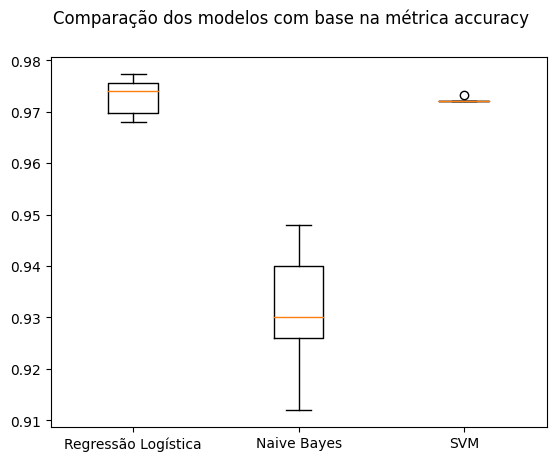

Regressão Logística: 0.523410 (0.156651)
Naive Bayes: 0.238421 (0.047810)
SVM: 0.000000 (0.000000)


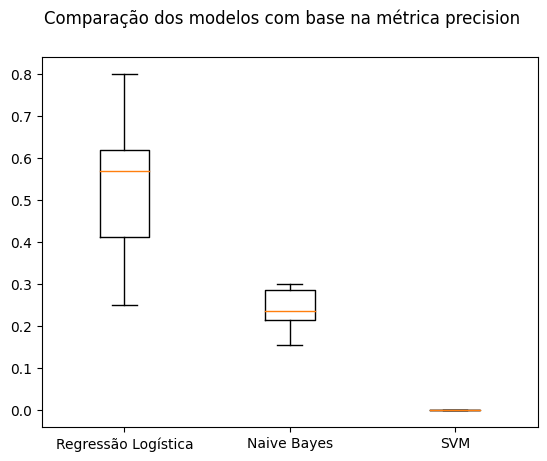

Regressão Logística: 0.234524 (0.101022)
Naive Bayes: 0.645238 (0.135714)
SVM: 0.000000 (0.000000)


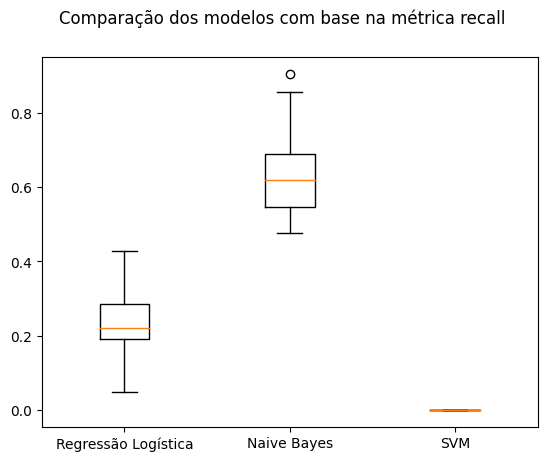

Regressão Logística: 0.193939 (0.081319)
Naive Bayes: 0.211517 (0.047545)
SVM: 0.000000 (0.000000)


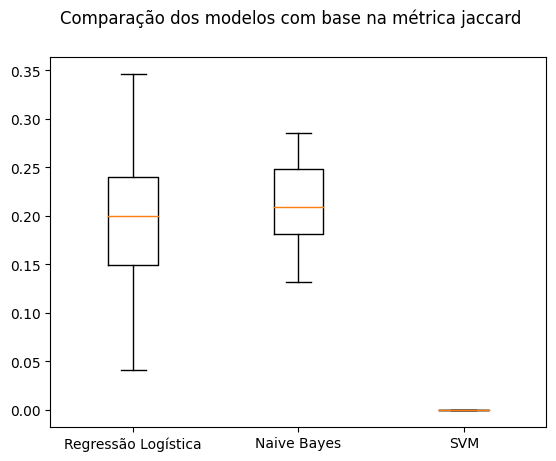

In [32]:
test_size = 0.25
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = seed)

num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratifi

np.random.seed(seed) # definindo uma semente global

scoring_list = ['accuracy', 'precision', 'recall', 'jaccard']

for scoring in scoring_list:
    models = list()

    # Preparando os modelos e adicionando-os em uma lista
    models.append(('Regressão Logística', LogisticRegression(max_iter=200)))
    models.append(('Naive Bayes', GaussianNB()))
    models.append(('SVM', SVC()))

    evaluate_model_based_on_scoring(models, X_train, y_train, kfold, scoring)



## **Avaliação de resultados**

Percebe-se que o modelo de regressão logística teve um resultado um pouco melhor, embora o Naive Bayes tenha tido um bom resultado para algumas métricas. Assim, o modelo de regressão logística será utilizado para o treinamento do conjunto de treino inteiro, e para as predições com o conjunto de teste.

In [33]:
def get_scoring_values(model, X_train, y_train, X_test, y_test):
    # Criando um modelo com todo o conjunto de treino
    model[1].fit(X_train, y_train)

    # Fazendo as predições com o conjunto de teste
    predictions = model[1].predict(X_test)

    # Estimando valor de métricas no conjunto de teste
    print("Métricas para o modelo " + model[0])
    print(accuracy_score(y_test, predictions))
    print(precision_score(y_test, predictions))
    print(jaccard_score(y_test, predictions))
    print(recall_score(y_test, predictions))
    print("\n")

model = ('Regressão Logística', LogisticRegression(max_iter=200))
get_scoring_values(model, X_train, y_train, X_test, y_test)

Métricas para o modelo Regressão Logística
0.9728
0.41379310344827586
0.15
0.19047619047619047




Assim, observa-se que o modelo realmente teve uma acurácia muito boa (muito próxima de 1). Com base nisso, não parece haver muita necessidade de otimizar hiperparâmetros, ou de métodos mais avançados e/ou complexos, ou de *ensembles*. Conforme visto nas aulas, é muito difícil conseguir um ótimo valor para todas as métricas.

Além disso, não parece ter havido overfitting nem de underfitting, pois o valor da acurácia do conjunto de treino e o do conjunto de teste são próximos.

#### **Comparação com outros modelos utilizando conjunto de teste**

In [34]:
models = list()
models.append(('Regressão Logística', LogisticRegression(max_iter=200)))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))

for model in models:
    get_scoring_values(model, X_train, y_train, X_test, y_test)

Métricas para o modelo Regressão Logística
0.9728
0.41379310344827586
0.15
0.19047619047619047


Métricas para o modelo Naive Bayes
0.9308
0.21649484536082475
0.19534883720930232
0.6666666666666666


Métricas para o modelo SVM
0.9748
0.0
0.0
0.0




In [35]:
def predict_by_color(predictions, X_test, target_index):
    matches = 0
    num_elements = len(X_test)
    for i in range(num_elements):
        element = X_test[i]
        if element[target_index] == 1 and predictions[i] == 1:
            matches += 1
    percentage = 100 * matches / num_elements
    print("Porcentagem de pessoas falecidas: " + str(percentage) + "%")

column_names = dataframe.columns.values.tolist()
num_names = len(column_names)
columns = list(range(num_names))
raca_dict = dict()

for i in range(num_names):
    name = column_names[i]
    if "raca_cor" in name and name not in raca_dict:
        key = name.replace("raca_cor_", "")
        raca_dict[key] = i

branca_index = raca_dict["BRANCA"]
negra_index = raca_dict["PRETA"]
parda_index = raca_dict["PARDA"]

predictions = models[0][1].predict(X_test) # Predições utilizando o modelo de regressão logística

print("BRANCOS:\n")
predict_by_color(predictions, X_test, branca_index)

print("\nNEGROS:\n")
predict_by_color(predictions, X_test, negra_index)

print("\nPARDOS:\n")
predict_by_color(predictions, X_test, parda_index)


BRANCOS:

Porcentagem de pessoas falecidas: 0.0%

NEGROS:

Porcentagem de pessoas falecidas: 1.16%

PARDOS:

Porcentagem de pessoas falecidas: 0.12%


Portanto, com base nesse modelo, os afrodescendentes (negros + pardos) tendem a falecer de covid-19 com mais frequência do que os brancos. Além disso, observa-se que, utilizando o conjunto de teste, o modelo de regressão logística teve um resultado melhor que o do Naive Bayes, mas com o valor de acurácia muito parecido com o do SVM.